# Disaster Tweets data analysis

In [14]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, ensemble, model_selection, pipeline, compose, preprocessing
# spacy.cli.download('en_core_web_sm')


In [15]:
df_train = pd.read_csv('./train.csv', index_col='id')
df_test = pd.read_csv('./test.csv', index_col='id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [16]:
df_train.sample(n=10)

,keyword,location,text,target
id,,,,
7742,panicking,NaN,you can stop panicking ?????? @ogtomd https:/...,0
5191,fatalities,"Caserta-Roma, Italy",Govt allocating 1.3 bn for flood action: Issue...,1
6402,hurricane,"Anderson, SC",hurricane?? sick!,1
10245,volcano,NaN,@lexi_purduee the volcano by it ??????,0
2890,damage,NaN,Devil May Cry 4 Special Edition Vergil Vs Agnu...,0
8296,rubble,NaN,@accionempresa ChinaÛªs stock market crash th...,1
4852,evacuation,"Bend, Oregon",Update: More from Bend FD on how a natural gas...,1
6793,lightning,Reddit,Lightning strike in the distance via /r/pics h...,1
1956,burning%20buildings,NaN,Ah yes the gays are totally destroying America...,0


In [17]:
df_train.fillna(value={'keyword': '', 'location': ''}, inplace=True)
df_train.sample(n=10)

,keyword,location,text,target
id,,,,
5245,fatality,"Houston, TX",@Chrisman528 fatality ...,0
1996,bush%20fires,Loughborough.,@JohnFromCranber Pleas FOR global warming don...,1
10852,,,#??? #?? #??? #??? MH370: Aircraft debris foun...,1
10112,upheaval,,R'lyeh by Upheaval http://t.co/829n4HJHOL,0
118,accident,Your Sister's Bedroom,I was in a horrible car accident this past Sun...,1
1483,body%20bags,,Child Shoulder Bags PVC Shoulder Book Bag Cart...,0
4962,explosion,"London, UK",EE recalls Power Bar phone chargers after expl...,1
10059,typhoon,Savage States of America,Map: Typhoon Soudelor's predicted path as it a...,1
1415,body%20bag,,#handbag #fashion #style http://t.co/hPd3SNM6o...,0


## Features selection

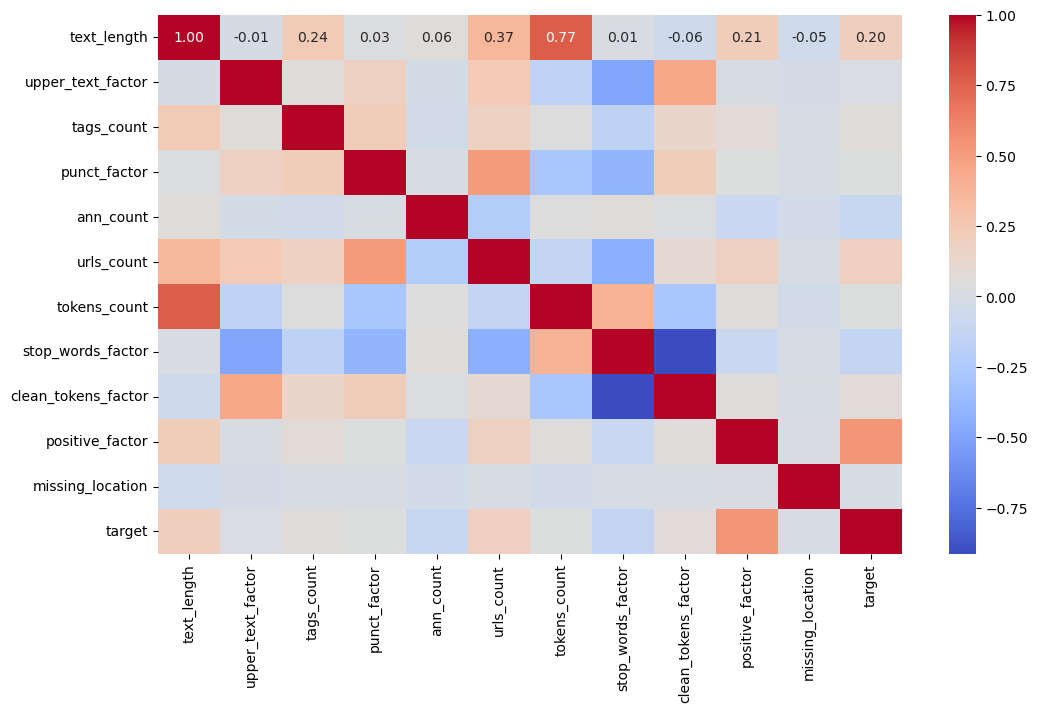

In [27]:
selected_features = ['text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 'urls_count',
                     'tokens_count', 'stop_words_factor', 'clean_tokens_factor', 'positive_factor',
                     'missing_location',
                     'target']
df_corr = df_train_enriched[selected_features].corr()

plt.figure(figsize=(12, 7))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=df_corr.columns, yticklabels=df_corr.columns)
plt.show()